# Gausian beam estimates for CMB-S4 SATs

JER, 6/23/2024

This is an update for the "maximum mapping speed" SAT models of June 2024.

We use Goldsmith's equation 6.41, the FWHM for a truncated gaussian

$$ \theta_{fwhm} = [1.02 + 0.0135 T_e] \frac{\lambda}{D} $$

where $T_e$ is the edge taper in decibels.  This formula assumes the shape of the illumination inside the aperture is reasonably Gaussian and well-described by the edge taper.

I use LAT-MF horn simulations from Sara Simon to derive edge tapers for the MF_1 and MF_2 channels, and scale those to other bands.  I check that scaling by comparing with the Sara's SAT-MF2 horn simulation, and find reasonable (but not terrific) agreement.  I also check the "Gaussian-ness" of those beams inside the aperture (by eye) and find they're pretty good.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 8]

c = 299792458 #m/s

In [2]:
!ls

ApertureFuncs                    SAT_models_outputs_20240619.toml
BeamEstimates.ipynb              atmos
S4_LAT_MF_v11_3_mag.csv          mapping_speed_ratios.txt
S4_SAT_MF2_v6_38_mag.csv         yamls
SAT_NETs_Chile.ipynb


# LAT-MF beam sims
These are from Sara Simon, for the 5.3mm LAT-MF horn, from 70 to 175GHz.

Let's look at the beams first, before we use them to find edge tapers.

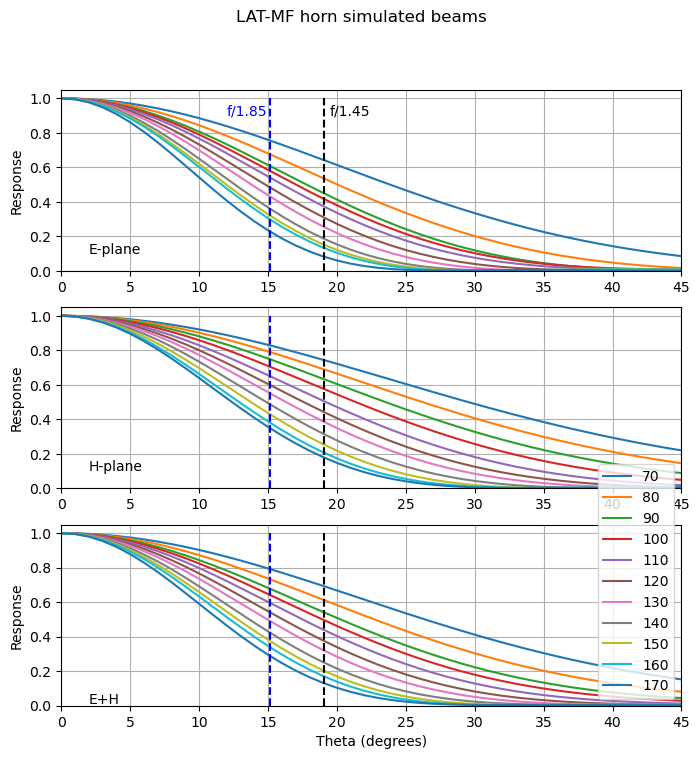

In [3]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [8,8]
plt.tight_layout()

#This file has theta in column 1, followed by sets of 3 columns for each frequency from 70GHz to 175GHz in units of 1GHz.
data=np.genfromtxt('S4_LAT_MF_v11_3_mag.csv', delimiter=',', skip_header=1)
theta=data[:,0]

fmin=70
fmax=175

freq_vec = np.arange(fmin,fmax+1, 10)

fnumber = 1.45
theta_stop1 = (180/np.pi)*np.arctan(1/(2*fnumber))
fnumber = 1.85
theta_stop2 = (180/np.pi)*np.arctan(1/(2*fnumber))

for freq in freq_vec:
    E_ind = 1+3*(freq-fmin)
    H_ind = 3+3*(freq-fmin)
    #Get beams
    E=data[:,E_ind]
    H=data[:,H_ind]
    #Normalize
    e_ampl=E/np.max(E)
    h_ampl=H/np.max(H)
    # Power, averaging over E plane and H plane.
    e_beam = e_ampl**2
    h_beam = h_ampl**2
    #
    plt.subplot(3,1,1)
    plt.plot(theta,e_beam,label=str(freq))
    #
    plt.subplot(3,1,2)
    plt.plot(theta,h_beam,label=str(freq))
    #
    plt.subplot(3,1,3)
    plt.plot(theta,(e_beam+h_beam)/2,label=str(freq))

for row in [1,2,3]:
    plt.subplot(3,1,row)
    plt.plot([theta_stop1,theta_stop1],[0,1],'--k')
    plt.plot([theta_stop2,theta_stop2],[0,1],'--b')
    plt.xlim(0,45)
    plt.ylabel('Response')
    plt.ylim(0)
    plt.grid()

plt.subplot(3,1,1)
plt.text(2,0.1,'E-plane')
plt.text(12,0.9,'f/1.85',color='blue')
plt.text(19.5,0.9,'f/1.45')

plt.subplot(3,1,2)
plt.text(2,0.1,'H-plane')

plt.subplot(3,1,3)
plt.text(2,0.01,'E+H')
plt.xlabel('Theta (degrees)')
plt.legend()

plt.suptitle('LAT-MF horn simulated beams');


# SAT-MF horn
Also from Sara Simon

This file is organized differently.  The first third is E-plane (phi=0). The second third is phi=45.  The last third is H-plane (phi=90).

Within each block of fixed phi, the data run from 82-175GHz in 1GHz increments, where at each frequency there are lines running from 0 to 180deg.

82-175GHz, 0-180deg, Eplane then Hplane.

Text(0.5, 0, 'Theta (deg)')

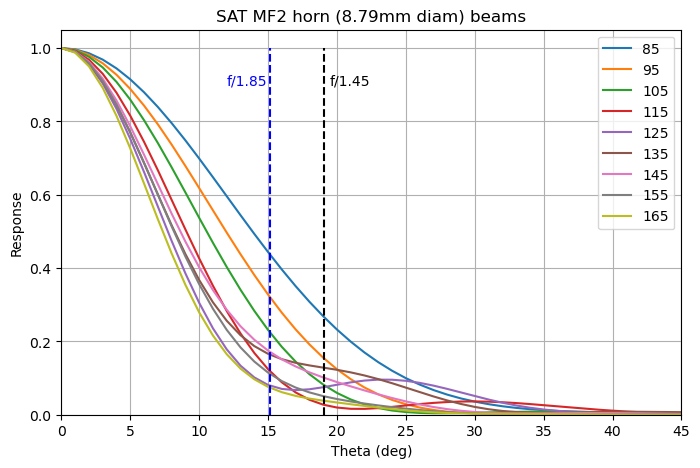

In [4]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [8,5]
plt.tight_layout()

fnumber = 1.45
theta_stop1 = (180/np.pi)*np.arctan(1/(2*fnumber))
fnumber = 1.85
theta_stop2 = (180/np.pi)*np.arctan(1/(2*fnumber))

theta_vec = np.arange(0,181)  # 0 to 180 inclusive
freq_vec = np.arange(82,176)  # 0 to 175 inclusive
E_start_ind = 0 # to start
H_start_ind = 2*len(theta_vec)*len(freq_vec)  # each phi block is len(freq_vec)*len(theta_vec) long

#This file has theta in column 1, followed by sets of 3 columns for each frequency from 70GHz to 175GHz in units of 1GHz.
data=np.genfromtxt('S4_SAT_MF2_v6_38_mag.csv', delimiter=',', skip_header=1)

for freq in np.arange(85,175,10):
    delta_f = freq-freq_vec[0]

    E_ind = E_start_ind + len(theta_vec)*delta_f.astype(int)
    H_ind = H_start_ind + len(theta_vec)*delta_f.astype(int)

    E=data[E_ind:E_ind+len(theta_vec),3]  # third column has relevant field
    H=data[H_ind:H_ind+len(theta_vec),3]
    
    e_ampl=E/np.max(E)
    h_ampl=H/np.max(H)

    beam = (e_ampl**2 + h_ampl**2)/2

    # Save if f=95GHz, for future use
    if freq == 95:
        SAT_MF2_beam95 = np.copy(beam)
        SAT_MF2_theta = np.copy(theta_vec)
    if freq == 155:
        SAT_MF2_beam155 = np.copy(beam)

    plt.plot(theta_vec,beam, label=str(freq))


plt.plot([theta_stop1,theta_stop1],[0,1],'--k')
plt.plot([theta_stop2,theta_stop2],[0,1],'--b')
plt.text(12,0.9,'f/1.85',color='blue')
plt.text(19.5,0.9,'f/1.45')

plt.xlim(0,45)
plt.ylabel('Response')
plt.ylim(0)
plt.legend()
plt.grid()

plt.title('SAT MF2 horn (8.79mm diam) beams')
plt.xlabel('Theta (deg)')


# Scaling with horn diameter and frequency

The beam pattern shown above should scale in theta as the horn diameter and frequency are changed.  To illustrate the frequency scaling, let's apply the expected $\theta \propto 1/\nu$, and overplot the same traces.

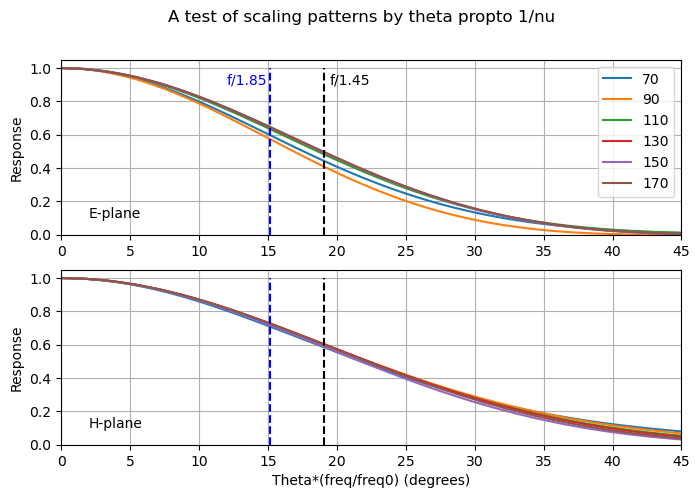

In [5]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [8,5]

#This file has theta in column 1, followed by sets of 3 columns for each frequency from 70GHz to 175GHz in units of 1GHz.
data=np.genfromtxt('S4_LAT_MF_v11_3_mag.csv', delimiter=',', skip_header=1)
theta=data[:,0]

fmin=70
fmax=175

freq_vec = np.arange(fmin,fmax+1, 20)

fnumber = 1.45
theta_stop1 = (180/np.pi)*np.arctan(1/(2*fnumber))
fnumber = 1.85
theta_stop2 = (180/np.pi)*np.arctan(1/(2*fnumber))
freq0 = 95 #GHz

for freq in freq_vec:
    E_ind = 1+3*(freq-fmin)
    H_ind = 3+3*(freq-fmin)
    #Get beams
    E=data[:,E_ind]
    H=data[:,H_ind]
    #Normalize
    e_ampl=E/np.max(E)
    h_ampl=H/np.max(H)
    # Power, averaging over E plane and H plane.
    e_beam = e_ampl**2
    h_beam = h_ampl**2
    #
    theta_f = theta*(freq/freq0)
    plt.subplot(2,1,1)
    plt.plot(theta_f,e_beam,label=str(freq))
    #
    plt.subplot(2,1,2)
    plt.plot(theta_f,h_beam)

for row in [1,2]:
    plt.subplot(2,1,row)
    plt.plot([theta_stop1,theta_stop1],[0,1],'--k')
    plt.plot([theta_stop2,theta_stop2],[0,1],'--b')
    plt.xlim(0,45)
    plt.ylabel('Response')
    plt.ylim(0)
    plt.grid()

plt.subplot(2,1,1)
plt.text(2,0.1,'E-plane')
plt.text(12,0.9,'f/1.85',color='blue')
plt.text(19.5,0.9,'f/1.45')

plt.legend()

plt.subplot(2,1,2)
plt.text(2,0.1,'H-plane')
plt.xlabel('Theta*(freq/freq0) (degrees)')

plt.suptitle('A test of scaling patterns by theta propto 1/nu');


This looks pretty good, though it's interesting that it's a better scaling in the H-plane than E-plane.

At fixed frequency, the horn pattern should scale in theta as $1/d_{horn}$.  So, in the patterns above, we would replace $\theta$ with $\theta*\left(\frac{5.2\mbox{\tiny mm}}{d_{horn}}\right)$.

So, let's plot a set of such (fictional) beam patterns as a function of horn diamter, at fixed frequency, and compare them with the actual SAT-MF2 horn beams where possible, and with a "by eye" Gaussian.

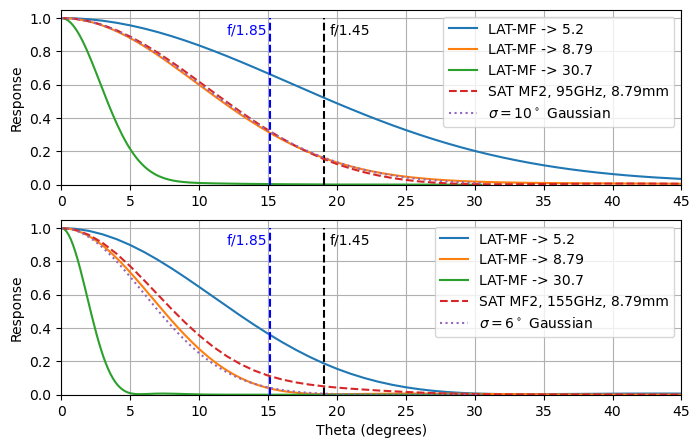

In [6]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.figsize'] = [8,5]

#This file has theta in column 1, followed by sets of 3 columns for each frequency from 70GHz to 175GHz in units of 1GHz.
data=np.genfromtxt('S4_LAT_MF_v11_3_mag.csv', delimiter=',', skip_header=1)
theta=data[:,0]

fmin=70
fmax=175

freq_vec = np.arange(fmin,fmax+1, 20)

fnumber = 1.45
theta_stop1 = (180/np.pi)*np.arctan(1/(2*fnumber))
fnumber = 1.85
theta_stop2 = (180/np.pi)*np.arctan(1/(2*fnumber))

freq0 = 155 #GHz

ii = 0
for freq0 in [95,155]: # so we can compare with SAT MF2
    ii +=1
    plt.subplot(2,1,ii)
    E_ind = 1+3*(freq0-fmin)
    H_ind = 3+3*(freq0-fmin)
    #Get beams
    E=data[:,E_ind]
    H=data[:,H_ind]
    #Normalize
    e_ampl=E/np.max(E)
    h_ampl=H/np.max(H)
    # Power, averaging over E plane and H plane.
    e_beam = e_ampl**2
    h_beam = h_ampl**2
    beam= (e_beam + h_beam)/2
    
    for dhorn in [5.2,8.79, 30.7]:
        #
        theta_f = theta*(5.2/dhorn)
        plt.plot(theta_f,beam,label='LAT-MF -> '+str(dhorn))
        #
    
    plt.plot([theta_stop1,theta_stop1],[0,1],'--k')
    plt.plot([theta_stop2,theta_stop2],[0,1],'--b')
    plt.xlim(0,45)
    plt.ylabel('Response')
    plt.ylim(0)
    plt.grid()
    
    plt.text(12,0.9,'f/1.85',color='blue')
    plt.text(19.5,0.9,'f/1.45')
    


    if ii==1:
        plt.plot(SAT_MF2_theta, SAT_MF2_beam95,'--',label='SAT MF2, 95GHz, 8.79mm')
        sigma=10
        gbeam = np.exp((-theta_f**2/(2*(sigma)**2)))
        plt.plot(theta_f,gbeam,':',label='$\sigma = 10^\circ$ Gaussian')

    if ii==2:
        plt.plot(SAT_MF2_theta, SAT_MF2_beam155,'--',label='SAT MF2, 155GHz, 8.79mm')
        plt.xlabel('Theta (degrees)')
        sigma=6
        gbeam = np.exp((-theta_f**2/(2*(sigma)**2)))
        plt.plot(theta_f,gbeam,':',label='$\sigma = 6^\circ$ Gaussian')
    plt.legend()


The plot above shows that the scaling of the 5.2mm horn pattern to the 8.79mm horn does really well at 95GHz, 
but shrinks it a little too much at 155GHz.  The Gaussian beam lines show that the orange line is well-fit by a Gaussian with a very similar edge taper.  The error at 155 GHz will lead to too-concentrated illumination on the stop, and therefore an overestimate of the FWHM beam on the sky.

Therefore we'll proceed with this method of estimating, but recognize that it's not great as we move to larger horns (eg the original SAT LF's)


# The models
Let's define the four instruments we're interested in.

In [7]:
SAT_models = {'Pole_orig':{},'Pole_max':{}} #,'Chile_AoAAlt3':{},'Chile_max':{}}
SAT_models['Pole_orig']={  # Pole baseline
    'fnum':1.45,
    'D_stop':0.560, #m
    'channels':{
        'LF_1':{
            'dhorn': 31.0, #mm
            'f_low': 21.5,
            'f_high': 28.0
        },
        'LF_2':{
            'dhorn': 31.0, #mm
            'f_low': 28.0,
            'f_high': 45.0
        },
        'MF1_1':{
            'dhorn': 9.35, #mm
            'f_low': 74.8,
            'f_high': 95.2
        },
        'MF1_2':{
            'dhorn': 9.35, #mm
            'f_low': 129.1,
            'f_high': 161
        },
        'MF2_1':{
            'dhorn': 8.79, #mm
            'f_low': 83.6,
            'f_high': 106.4
        },
        'MF2_2':{
            'dhorn': 8.79, #mm
            'f_low': 138,
            'f_high': 172.1
        },
        'HF_1':{
            'dhorn': 5.2, #mm
            'f_low': 198,
            'f_high': 256.0
        },
        'HF_2':{
            'dhorn': 5.2, #mm
            'f_low': 256.0,
            'f_high': 315.0
        }
    }
}

SAT_models['Pole_max']={  # Pole max mapping speed, no HWP
    'fnum':1.45,
    'D_stop':0.560, #m
    'channels':{
        'LF_1':{
            'dhorn': 19.1, #mm
            'f_low': 21.5,
            'f_high': 28.0
        },
        'LF_2':{
            'dhorn': 19.1, #mm
            'f_low': 28.0,
            'f_high': 45.0
        },
        'MF1_1':{
            'dhorn': 5.2, #mm
            'f_low': 74.8,
            'f_high': 95.2
        },
        'MF1_2':{
            'dhorn': 5.2, #mm
            'f_low': 129.1,
            'f_high': 161
        },
        'MF2_1':{
            'dhorn': 5.2, #mm
            'f_low': 83.6,
            'f_high': 106.4
        },
        'MF2_2':{
            'dhorn': 5.2, #mm
            'f_low': 138,
            'f_high': 172.1
        },
        'HF_1':{
            'dhorn': 5.2, #mm
            'f_low': 198,
            'f_high': 256.0
        },
        'HF_2':{
            'dhorn': 5.2, #mm
            'f_low': 256.0,
            'f_high': 315.0
        }
    }
}

SAT_models['Chile_AoAAlt3']={  # Chile HWP, scaled optics
    'fnum':1.45,
    'D_stop':0.440, #m
    'channels':{
        'LF_1':{
            'dhorn': 31.0, #mm
            'f_low': 21.5,
            'f_high': 28.0
        },
        'LF_2':{
            'dhorn': 31.0, #mm
            'f_low': 28.0,
            'f_high': 45.0
        },
        'MF1_1':{
            'dhorn': 9.4, #mm
            'f_low': 74.8,
            'f_high': 95.2
        },
        'MF1_2':{
            'dhorn': 9.4, #mm
            'f_low': 129.1,
            'f_high': 161
        },
        'MF2_1':{
            'dhorn': 8.79, #mm
            'f_low': 83.6,
            'f_high': 106.4
        },
        'MF2_2':{
            'dhorn': 8.79, #mm
            'f_low': 138,
            'f_high': 172.1
        },
        'HF_1':{
            'dhorn': 5.2, #mm
            'f_low': 198,
            'f_high': 256.0
        },
        'HF_2':{
            'dhorn': 5.2, #mm
            'f_low': 256.0,
            'f_high': 315.0
        }
    }
}

SAT_models['Chile_max']={  # Chile HWP, scaled optics
    'fnum':1.85,
    'D_stop':0.440, #m
    'channels':{
        'LF_1':{
            'dhorn': 19.1, #mm
            'f_low': 21.5,
            'f_high': 28.0
        },
        'LF_2':{
            'dhorn': 19.1, #mm
            'f_low': 28.0,
            'f_high': 45.0
        },
        'MF1_1':{
            'dhorn': 5.2, #mm
            'f_low': 74.8,
            'f_high': 95.2
        },
        'MF1_2':{
            'dhorn': 5.2, #mm
            'f_low': 129.1,
            'f_high': 161
        },
        'MF2_1':{
            'dhorn': 5.2, #mm
            'f_low': 83.6,
            'f_high': 106.4
        },
        'MF2_2':{
            'dhorn': 5.2, #mm
            'f_low': 138,
            'f_high': 172.1
        },
        'HF_1':{
            'dhorn': 5.2, #mm
            'f_low': 198,
            'f_high': 256.0
        },
        'HF_2':{
            'dhorn': 5.2, #mm
            'f_low': 256.0,
            'f_high': 315.0
        }
    }
}

# SAT_models['Chile_AoAAlt3']={  # Atacama AoA scaled optics
#     'yaml':'SAT_HWP_AoAscaledoptics_20220726.yaml',
# }

# SAT_models['Chile_max']={  # Atacama max mapping speed w/ HWP
#     'yaml':'SAT_HWP_max_20240618.yaml', # base yaml file to start with before mods
# }

In [8]:
#This file has theta in column 1, followed by sets of 3 columns for each frequency from 70GHz to 175GHz in units of 1GHz.
data=np.genfromtxt('S4_LAT_MF_v11_3_mag.csv', delimiter=',', skip_header=1)
freq_filemin=70
freq_filemax=175
theta=data[:,0]

print('#Model         Channel    f/#    theta_stop f_min f_max ET_val ET_dB sky_fwhm_arcmin')

for model in SAT_models.keys():
    for ch in SAT_models[model]['channels'].keys():
        dhorn = SAT_models[model]['channels'][ch]['dhorn']
        fmin = np.round(SAT_models[model]['channels'][ch]['f_low'],0)
        fmax = np.round(SAT_models[model]['channels'][ch]['f_high'],0)
        fmid = (fmin+fmax)/2
        freq_vec = np.arange(fmin,fmax+1).astype(int)
        theta_horncorrected = theta*(5.2/dhorn)
    
        fnumber = SAT_models[model]['fnum']
        theta_stop = (180/np.pi)*np.arctan(1/(2*fnumber))

        # pivot frequency for beam scalings
        f0 = np.sqrt(freq_filemin*freq_filemax).astype(int) # GHz, the geometric mean of the high and low frequencies in the file.

        # calculate the beam at the pivot frequency
        E_ind = 1+3*(f0-freq_filemin)
        H_ind = 3+3*(f0-freq_filemin)
        #Get beams
        E=data[:,E_ind]
        H=data[:,H_ind]
        #Normalize
        e_ampl=E/np.max(E)
        h_ampl=H/np.max(H)
        # Power, averaging over E plane and H plane.
        beam = (e_ampl**2 + h_ampl**2)/2
        
        beam_val_at_stop_vec = np.array([])
        for freq in freq_vec:
            theta_final = theta_horncorrected*(f0/freq)
            beam_val_at_stop = np.interp(theta_stop,theta_final,beam)
            beam_val_at_stop_vec = np.append(beam_val_at_stop_vec, beam_val_at_stop)
                
        beam_val_at_stop_avg = np.mean(beam_val_at_stop_vec)
        taper_dB = -10*np.log10(beam_val_at_stop_avg)  # take the negative to make it positive.
        lambda_mid = c/(fmid*1e9)
        theta_sky_fwhm_rad = (1.02 + 0.0135*taper_dB)*lambda_mid/(SAT_models[model]['D_stop']) 
        theta_sky_fwhm_arcmin = 60.0*(180/np.pi)*theta_sky_fwhm_rad
        print(f'{model.ljust(15)} {ch.ljust(6)} {fnumber:6.2f} {theta_stop:9.1f} {fmin:6.0f} {fmax:6.0f} {beam_val_at_stop_avg:8.3f} {taper_dB:8.2f} {theta_sky_fwhm_arcmin:8.1f}')

        SAT_models[model]['channels'][ch]['EdgeTaperVal'] = beam_val_at_stop_avg
        SAT_models[model]['channels'][ch]['EdgeTaperdB'] = taper_dB
        SAT_models[model]['channels'][ch]['Sky_fwhm_arcmin'] = theta_sky_fwhm_arcmin
    print()
            

#Model         Channel    f/#    theta_stop f_min f_max ET_val ET_dB sky_fwhm_arcmin
Pole_orig       LF_1     1.45      19.0     22     28    0.225     6.48     81.5
Pole_orig       LF_2     1.45      19.0     28     45    0.055    12.58     60.0
Pole_orig       MF1_1    1.45      19.0     75     95    0.208     6.83     24.1
Pole_orig       MF1_2    1.45      19.0    129    161    0.014    18.44     16.1
Pole_orig       MF2_1    1.45      19.0     84    106    0.177     7.53     21.7
Pole_orig       MF2_2    1.45      19.0    138    172    0.014    18.58     15.1
Pole_orig       HF_1     1.45      19.0    198    256    0.035    14.58      9.9
Pole_orig       HF_2     1.45      19.0    256    315    0.009    20.66      8.4

Pole_max        LF_1     1.45      19.0     22     28    0.565     2.48     77.5
Pole_max        LF_2     1.45      19.0     28     45    0.305     5.15     54.9
Pole_max        MF1_1    1.45      19.0     75     95    0.613     2.12     22.7
Pole_max        MF1_2  

The final column is the one of interest.

In [9]:
print('6/23/2024')
print('SAT model fwhm on-sky beams, using Gaussian+edge taper approximation')
print('Model            LF_1   LF_2   MF1_1  MF1_2  MF2_1  MF2_2   HF_1  HF_2')
for model in SAT_models.keys():
    print(model.ljust(14),end='')
    for ch in SAT_models[model]['channels'].keys():
        print(f"{SAT_models[model]['channels'][ch]['Sky_fwhm_arcmin']:7.1f}",end='')
    print()
        

6/23/2024
SAT model fwhm on-sky beams, using Gaussian+edge taper approximation
Model            LF_1   LF_2   MF1_1  MF1_2  MF2_1  MF2_2   HF_1  HF_2
Pole_orig        81.5   60.0   24.1   16.1   21.7   15.1    9.9    8.4
Pole_max         77.5   54.9   22.7   14.0   20.5   13.2    9.9    8.4
Chile_AoAAlt3   103.8   76.4   30.7   20.5   27.7   19.2   12.6   10.7
Chile_max        97.5   68.3   28.6   17.3   25.7   16.3   11.8   10.0
